In [1]:
import numpy as np
import pandas as pd
import json
import itertools
import ast
import collections
import gc

In [120]:
# for reviews 
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
import seaborn as sns

In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

C:\Anaconda\envs\env_yelp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True, rc={'figure.figsize':(10,7)})
params = { 
    'axes.labelsize': "medium",
    'xtick.labelsize': 'medium',
    'legend.fontsize': 10,
    'figure.dpi': 100,
    'figure.figsize': [10, 7]
}
plt.rcParams.update(params)

### Helper Functions

In [5]:
def strip_element(my_list):
    if(my_list!=None):
        return [x.strip() for x in my_list]
    else:
        return None

In [6]:
def count_element(my_list, word):
    if(my_list!=None):
        return [elem for elem in my_list].count(word)
    else:
        return None

In [7]:
def elem_type(val):
    x=str(type(val))
    x=x.replace("<","")
    x=x.replace(">","")
    x=x.replace("\'","")
    x=x.split()[1]
    return(x)

# Read & Explore Business data

In [8]:
%%time
business1 = []
with open('./data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as f:
    for line in f:
        business1.append(json.loads(line))
print(business1[0])

{'business_id': 'f9NumwFMBDn751xgFiRbNA', 'name': 'The Range At Lake Norman', 'address': '10913 Bailey Rd', 'city': 'Cornelius', 'state': 'NC', 'postal_code': '28031', 'latitude': 35.4627242, 'longitude': -80.8526119, 'stars': 3.5, 'review_count': 36, 'is_open': 1, 'attributes': {'BusinessAcceptsCreditCards': 'True', 'BikeParking': 'True', 'GoodForKids': 'False', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", 'ByAppointmentOnly': 'False', 'RestaurantsPriceRange2': '3'}, 'categories': 'Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping', 'hours': {'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0', 'Wednesday': '10:0-18:0', 'Thursday': '11:0-20:0', 'Friday': '11:0-20:0', 'Saturday': '11:0-20:0', 'Sunday': '13:0-18:0'}}
Wall time: 2.88 s


### Convert json data to pandas dataframe

In [9]:
business=pd.DataFrame.from_dict(business1)

In [10]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.46,-80.85,3.50,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikeParking': 'True', 'GoodForKids': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'ByAppointmentOnly': 'False', 'RestaurantsPriceRange2': '3'}","Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0', 'Wednesday': '10:0-18:0', 'Thursday': '11:0-20:0', 'Friday': '11:0-20:0', 'Saturday': '11:0-20:0', 'Sunday': '13:0-18:0'}"
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.57,-111.89,5.00,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': 'True'}","Health & Medical, Fitness & Instruction, Yoga, Active Life, Pilates",None


### Extracting features from categories & Attribute columns

In [11]:
business["Is_Restaurant"]=None

#### Considered rows where 'Bar', 'Restaurants' & 'Food' exist in categories column as Restaurants. 

##### Other similar words like 'pub', sandwitches ect mostly co-occur with above 3 words in categories and hence not considered

In [12]:
business.loc[(business["categories"].str.contains("Bar")==True) | 
         (business["categories"].str.contains("Restaurants")==True) | 
         (business["categories"].str.contains("Food")==True),"Is_Restaurant"]=True

In [13]:
business.loc[business["Is_Restaurant"]!=True, "Is_Restaurant"]=False

#### Filtering out rows which are restaurants only

In [14]:
restaurants=business[business["Is_Restaurant"]==True].reset_index(drop=True)

In [15]:
restaurants.shape

(85798, 15)

In [16]:
## top 20 restaurant names by review count
restaurants.groupby('name')['review_count'].count().reset_index().sort_values('review_count',ascending=False).head(20)

,name,review_count
46084,Starbucks,1182
31110,McDonald's,854
46595,Subway Restaurants,613
52491,Tim Hortons,388
7211,Burger King,337
47928,Taco Bell,334
38316,Pizza Hut,330
55366,Wendy's,323
55126,Walgreens,316
10842,Circle K,279


In [17]:
# Since Subway Restaurants & Subway are same we'll rename 'Subway Restaurants' as 'Subway'
restaurants.loc[restaurants["name"]=="Subway Restaurants", "name"]="Subway"

#### Checking if attributes column is not null

In [18]:
restaurants["attribute_exists"]=restaurants["attributes"].apply(lambda x : elem_type(x))

#### understanding attributes frequency to select the relevent features

In [19]:
%%time

attrib_list = []
for loop in range(len(business1)):
    if (business1[loop]['attributes']!=None):
        #print("loop==", loop)
        for key, vals in business1[loop]["attributes"].items():
            #print("loop==", loop)
            attrib_list.append(key.strip())
    else:
        k=1
        #print("Skipping")

Wall time: 386 ms


In [20]:
%%time
attrib_dict=collections.Counter(attrib_list)
attrib_dict=collections.OrderedDict(attrib_dict.most_common())

Wall time: 129 ms


In [21]:
pd.DataFrame.from_dict(attrib_dict, orient = 'index').reset_index().rename(columns = { 0 :'Count', 'index':'Attribute'}).sort_values('Count', ascending = False)

,Attribute,Count
0,BusinessAcceptsCreditCards,122237
1,BusinessParking,115215
2,RestaurantsPriceRange2,111288
3,BikeParking,89765
4,GoodForKids,68535
5,RestaurantsTakeOut,66301
6,WiFi,65331
7,ByAppointmentOnly,60799
8,OutdoorSeating,58441
9,RestaurantsDelivery,56679


##### Selecting Relevent Features from the above list based on counts

In [22]:
restaurants["RestaurantsPriceRange2"]=None

In [23]:
restaurants.loc[restaurants["attribute_exists"]=="dict","RestaurantsPriceRange2"] = [d.get('RestaurantsPriceRange2')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [24]:
restaurants.loc[restaurants["RestaurantsPriceRange2"]=="None","RestaurantsPriceRange2"]=None

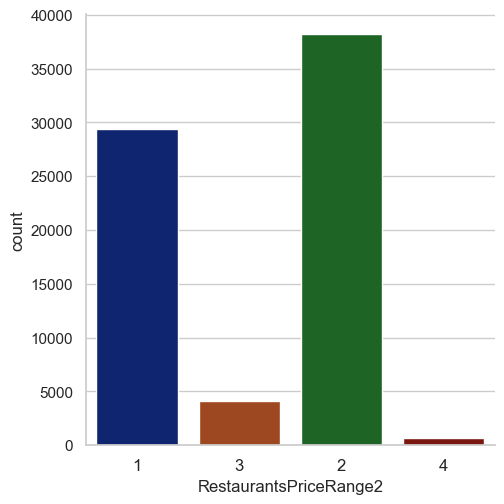

In [25]:
sns.catplot(x="RestaurantsPriceRange2", 
            data=restaurants, kind="count" )

We see that most of the restaurants are in the lower price range (1,2) and lesser in high end (3) and premium (4)

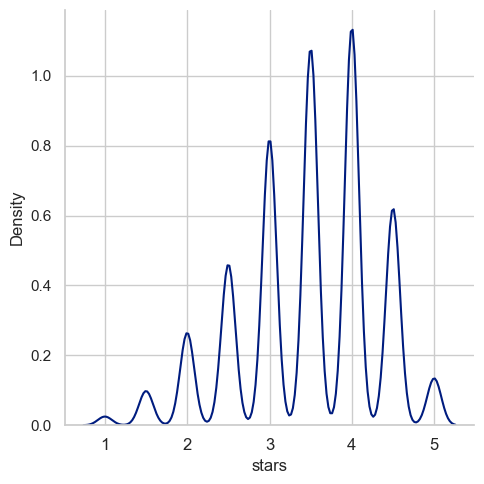

In [26]:
sns.displot(restaurants[restaurants["RestaurantsPriceRange2"].notnull()], 
            x="stars", kind="kde")

Most of the restaurants are between 3 to 4 stars

In [27]:
restaurants.loc[restaurants["RestaurantsPriceRange2"].notnull(),"stars"].describe()

count   72366.00
mean    3.47    
std     0.81    
min     1.00    
25%     3.00    
50%     3.50    
75%     4.00    
max     5.00    
Name: stars, dtype: float64

Lets look at stars vs price 

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


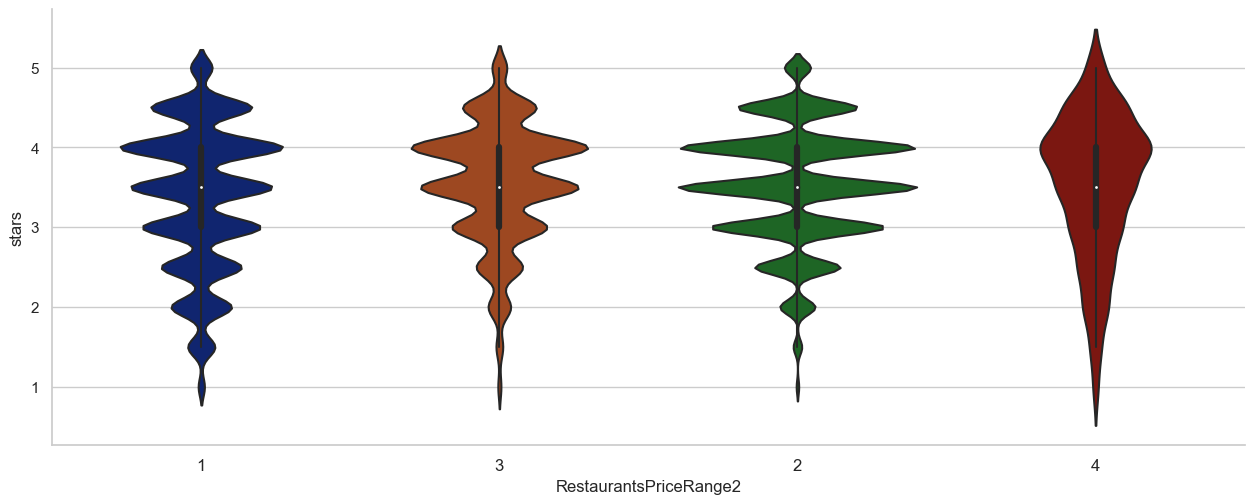

In [28]:
# sns.catplot(x="RestaurantsPriceRange2", hue="stars",  
#                 data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
#                                  kind="count") 

sns.factorplot(x='RestaurantsPriceRange2', 
               y='stars' ,
               data=restaurants[(restaurants["RestaurantsPriceRange2"].notnull()) ] , 
               kind='violin', aspect=2.5)

restaurant ratings & price ranges are not necesarily consistent as the stars count is high towards 4 stars
with an exception for premium restaurants (4) where their ratings skew higher

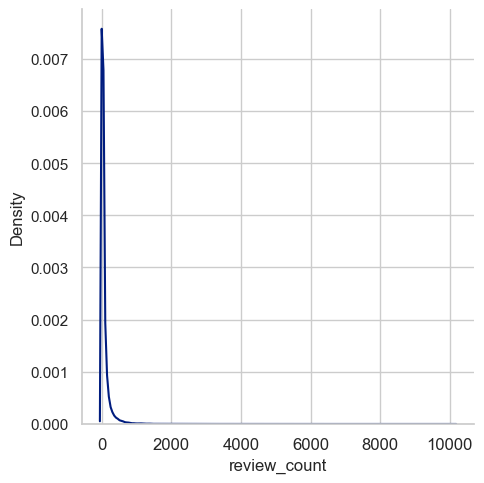

In [29]:
sns.displot(restaurants[restaurants["RestaurantsPriceRange2"].notnull()], 
            x="review_count", kind="kde")

Looks like review count has a long tail. Lets get basic decriptive stats for this feature

In [30]:
restaurants.loc[restaurants["RestaurantsPriceRange2"].notnull(),"review_count"].describe()

count   72366.00
mean    73.79   
std     190.75  
min     3.00    
25%     9.00    
50%     23.00   
75%     67.00   
max     10129.00
Name: review_count, dtype: float64

In [31]:
restaurants.loc[restaurants["RestaurantsPriceRange2"].notnull(),"review_count"].quantile(0.975)

460.875

To understand the review count distribution we'll cap the review count to 97.5 precentile

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


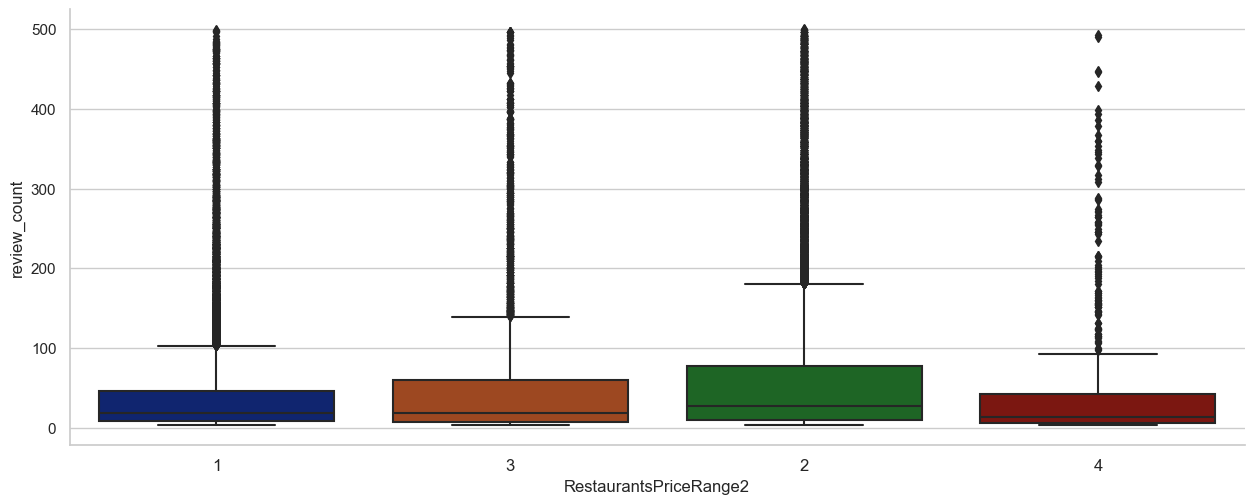

In [32]:
sns.factorplot(x='RestaurantsPriceRange2', 
               y='review_count' ,
               data=restaurants[(restaurants["RestaurantsPriceRange2"].notnull()) & 
                               (restaurants["review_count"]<=500)] , kind='box', aspect=2.5)

Though the premium restaurants (4) are reviewed lesser as compared to other categories of restaurants, l
ooks like there are quite a few exceptional places who have got good amount of reviews

In [33]:
restaurants["NoiseLevel"]=None

In [34]:
restaurants.loc[restaurants["attribute_exists"]=="dict","NoiseLevel"] = [d.get('NoiseLevel')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [35]:
restaurants["NoiseLevel"]=restaurants["NoiseLevel"].str.replace("u\'","\'")

In [36]:
restaurants["NoiseLevel"]=restaurants["NoiseLevel"].str.replace("\'","")

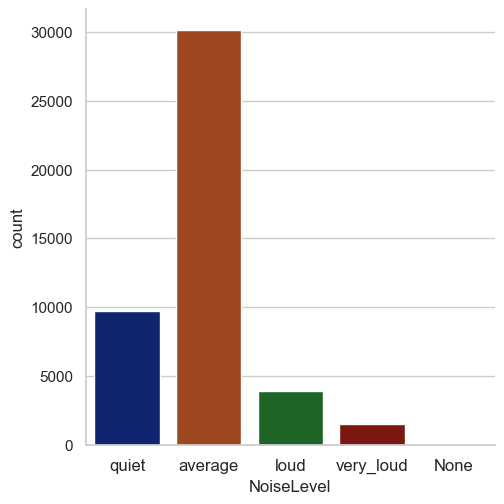

In [37]:
sns.catplot(x="NoiseLevel", 
            data=restaurants, kind="count" )

Most of the restaurants seems to have average noise level

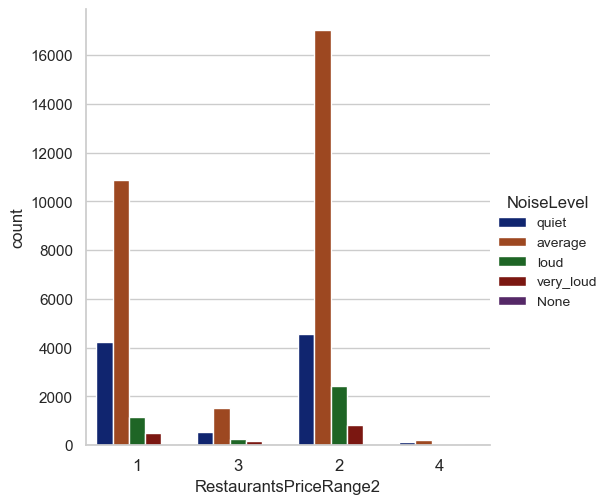

In [38]:
sns.catplot(x="RestaurantsPriceRange2",  hue="NoiseLevel",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count") 

In [39]:
restaurants["CoatCheck"]=None

In [40]:
restaurants.loc[restaurants["attribute_exists"]=="dict","CoatCheck"] = [d.get('CoatCheck')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [41]:
restaurants.loc[restaurants["CoatCheck"]=="None","CoatCheck"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


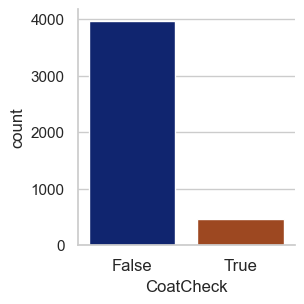

In [42]:
sns.catplot(x="CoatCheck", 
            data=restaurants, kind="count", size=3 )

Most of the restaurants don't seem to have coatcheck

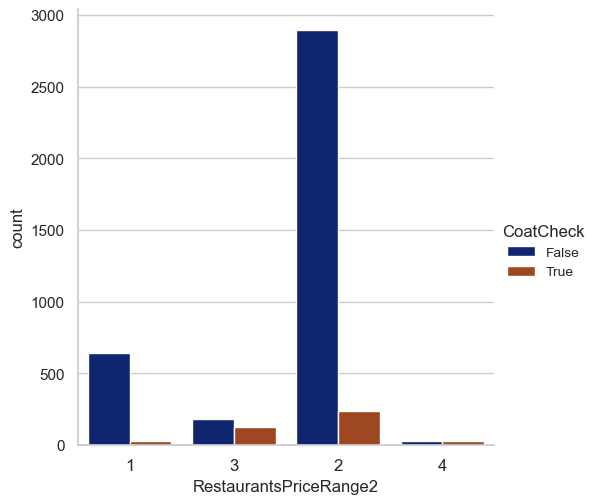

In [43]:
sns.catplot(x="RestaurantsPriceRange2",  hue="CoatCheck",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count") 

In [44]:
business["Alcohol"]=None

In [45]:
restaurants.loc[restaurants["attribute_exists"]=="dict","Alcohol"] = [d.get('Alcohol')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [46]:
restaurants["Alcohol"]=restaurants["Alcohol"].str.replace("u\'","\'")

In [47]:
restaurants.loc[restaurants["Alcohol"]=="\'none\'","Alcohol"]="NoAlcohol"

In [48]:
restaurants["Alcohol"]=restaurants["Alcohol"].str.replace("\'","")

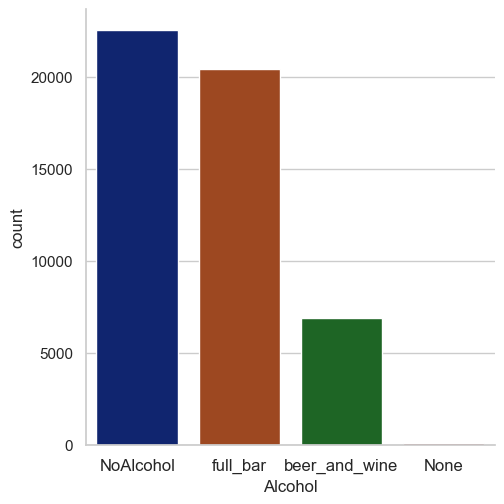

In [49]:
sns.catplot(x="Alcohol", 
            data=restaurants, kind="count")

Most of the restaurants don't serve alcohol

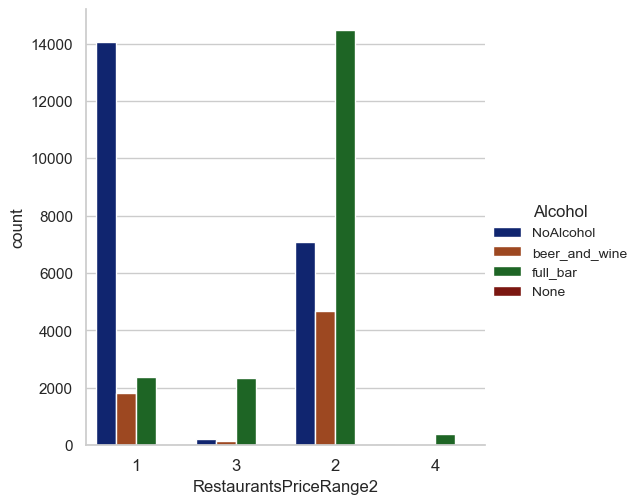

In [50]:
sns.catplot(x="RestaurantsPriceRange2",  hue="Alcohol",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

High End (3) & Premium(4) restaurants  mostly have a full bar

In [51]:
restaurants["BusinessAcceptsCreditCards"]=None

In [52]:
restaurants.loc[restaurants["attribute_exists"]=="dict","BusinessAcceptsCreditCards"] = [d.get('BusinessAcceptsCreditCards')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [53]:
restaurants.loc[restaurants["BusinessAcceptsCreditCards"]=="None","BusinessAcceptsCreditCards"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


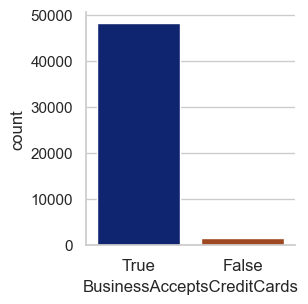

In [54]:
sns.catplot(x="BusinessAcceptsCreditCards", 
            data=restaurants, kind="count", size=3)

Most of the restaurants accept credit cards

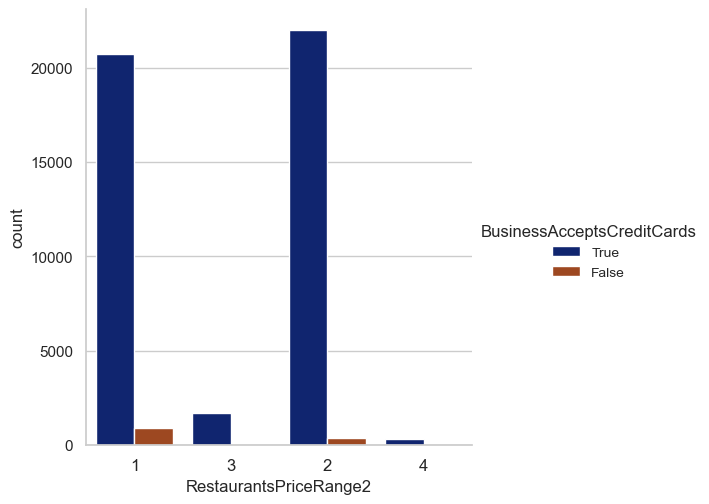

In [55]:
sns.catplot(x="RestaurantsPriceRange2",  hue="BusinessAcceptsCreditCards",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

all the high end & premium restaurants accept credit cards

In [56]:
restaurants["GoodForKids"]=None

In [57]:
restaurants.loc[restaurants["attribute_exists"]=="dict","GoodForKids"] = [d.get('GoodForKids')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [58]:
restaurants.loc[restaurants["GoodForKids"]=="None","GoodForKids"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


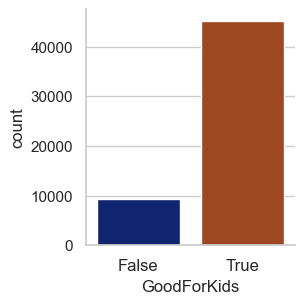

In [59]:
sns.catplot(x="GoodForKids", 
            data=restaurants, kind="count", size=3)

Most of the restaurants are Kids Friendly

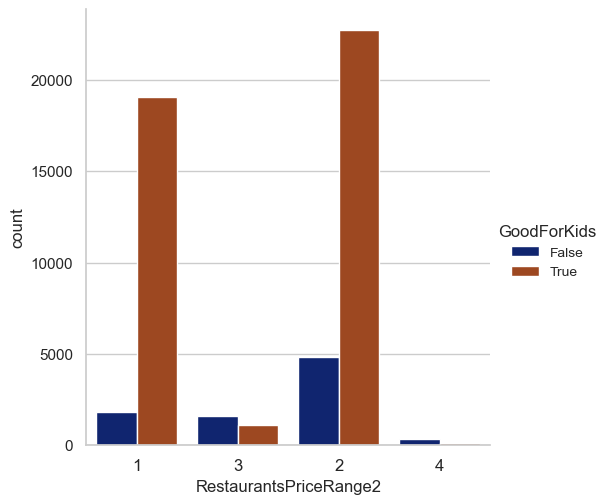

In [60]:
sns.catplot(x="RestaurantsPriceRange2",  hue="GoodForKids",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

Premium restaurants are not kids freindly (maybe because of the full bar)

In [61]:
restaurants["RestaurantsDelivery"]=None

In [62]:
restaurants.loc[restaurants["attribute_exists"]=="dict","RestaurantsDelivery"] = [d.get('RestaurantsDelivery')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [63]:
restaurants.loc[restaurants["RestaurantsDelivery"]=="None","RestaurantsDelivery"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


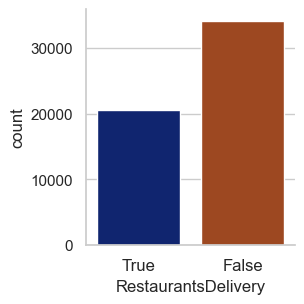

In [64]:
sns.catplot(x="RestaurantsDelivery", 
            data=restaurants, kind="count", size=3)

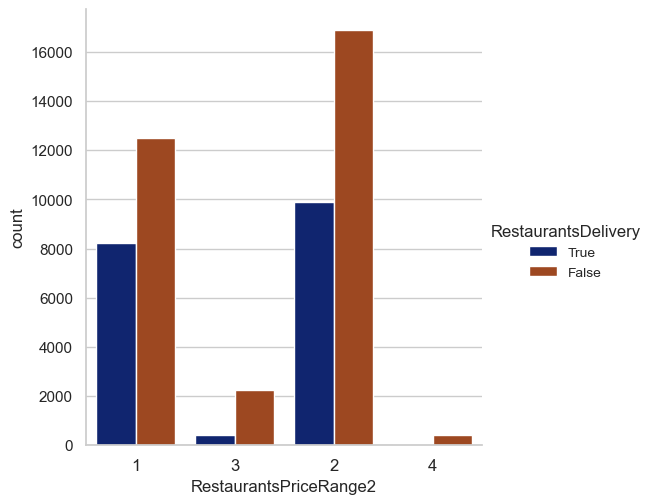

In [65]:
sns.catplot(x="RestaurantsPriceRange2",  hue="RestaurantsDelivery",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

High end & Premium restaurants mostly don't offer delivery

In [66]:
restaurants["RestaurantsTakeOut"]=None

In [67]:
restaurants.loc[restaurants["attribute_exists"]=="dict","RestaurantsTakeOut"] = [d.get('RestaurantsTakeOut')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [68]:
restaurants.loc[restaurants["RestaurantsTakeOut"]=="None","RestaurantsTakeOut"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


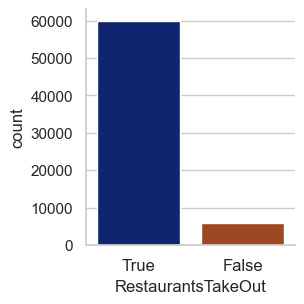

In [69]:
sns.catplot(x="RestaurantsTakeOut", 
            data=restaurants, kind="count", size=3)

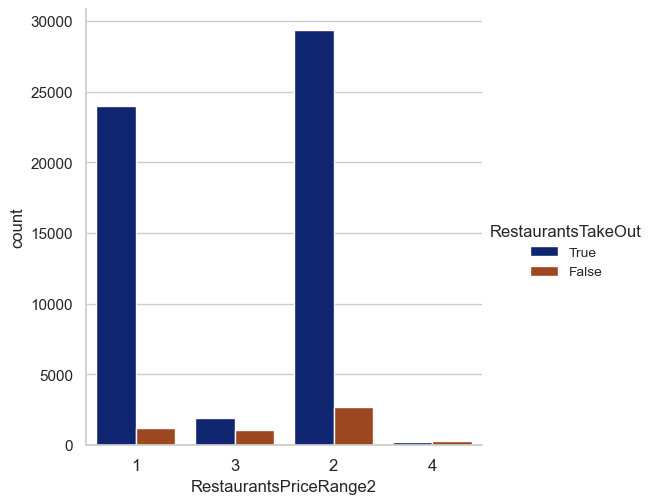

In [70]:
sns.catplot(x="RestaurantsPriceRange2",  hue="RestaurantsTakeOut",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

Though high end & premium don't offer much of a delivery, they do offer takeout"

In [71]:
restaurants["OutdoorSeating"]=None

In [72]:
restaurants.loc[restaurants["attribute_exists"]=="dict","OutdoorSeating"] = [d.get('OutdoorSeating')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [73]:
restaurants.loc[restaurants["OutdoorSeating"]=="None","OutdoorSeating"]=None

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


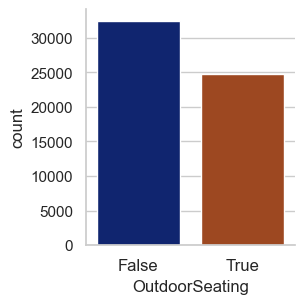

In [74]:
sns.catplot(x="OutdoorSeating", 
            data=restaurants, kind="count", size=3)

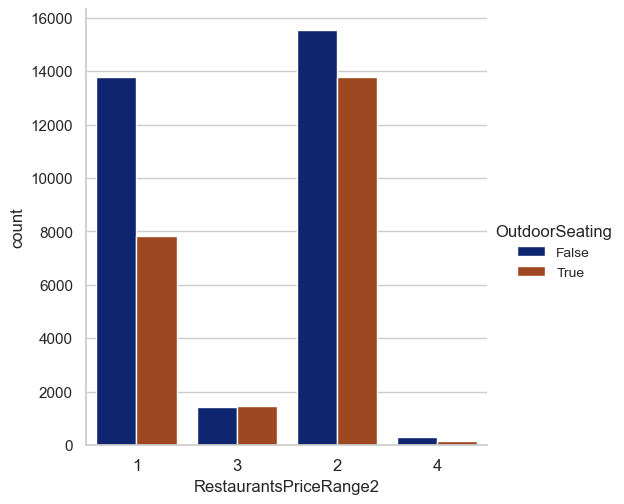

In [75]:
sns.catplot(x="RestaurantsPriceRange2",  hue="OutdoorSeating",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

No concrete inference with this feature

In [76]:
restaurants.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'Is_Restaurant',
       'attribute_exists', 'RestaurantsPriceRange2', 'NoiseLevel', 'CoatCheck',
       'Alcohol', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsDelivery', 'RestaurantsTakeOut', 'OutdoorSeating'],
      dtype='object')

In [77]:
restaurants["WiFi"]=None

In [78]:
restaurants.loc[restaurants["attribute_exists"]=="dict","WiFi"] = [d.get('WiFi')  for d in restaurants[restaurants["attribute_exists"]=="dict"]["attributes"]]

In [79]:
restaurants.loc[restaurants["WiFi"]=="None","WiFi"]=None

In [80]:
restaurants["WiFi"]=restaurants["WiFi"].str.replace("u\'","\'")

In [81]:
restaurants["WiFi"]=restaurants["WiFi"].str.replace("\'","")

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


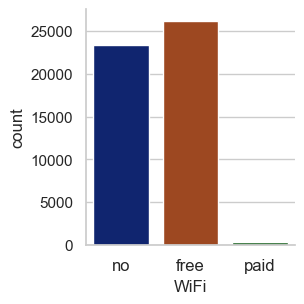

In [82]:
sns.catplot(x="WiFi", 
            data=restaurants, kind="count", size=3)

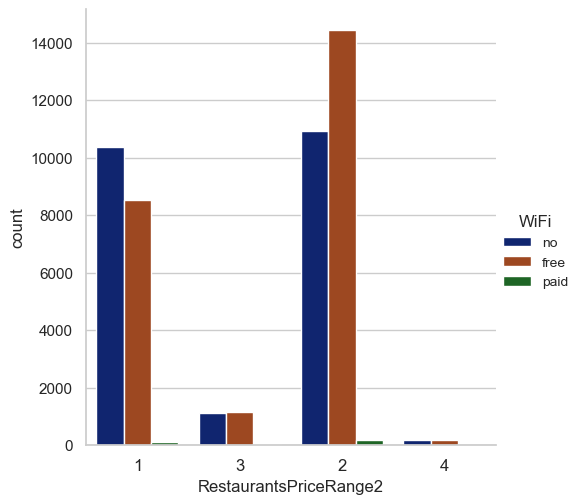

In [83]:
sns.catplot(x="RestaurantsPriceRange2",  hue="WiFi",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

No concrete inference for this feature

##### if restaurant is a chain

In [84]:
rest_type_chain=restaurants.groupby(["name"])["business_id"].count().reset_index().sort_values("business_id", ascending=False)

In [85]:
rest_type_chain["Is_chain"]=np.where(rest_type_chain["business_id"]>1, True,False)

In [86]:
restaurants=pd.merge(restaurants,rest_type_chain[["name","Is_chain"]], on="name", how="left" )

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


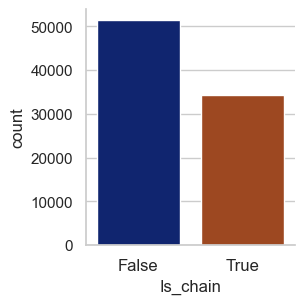

In [87]:
sns.catplot(x="Is_chain", 
            data=restaurants, kind="count", size=3)

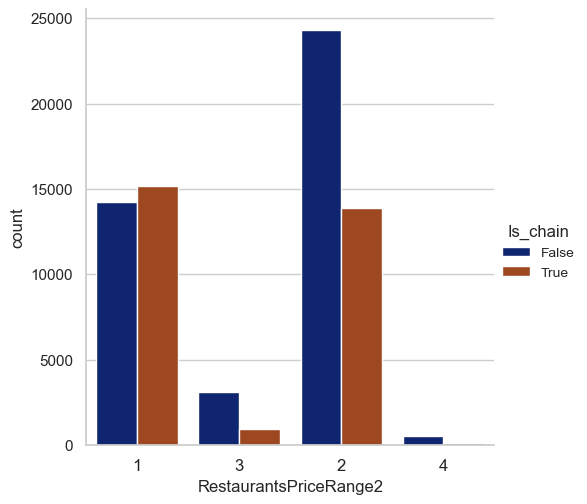

In [88]:
sns.catplot(x="RestaurantsPriceRange2",  hue="Is_chain",  
                data=restaurants[restaurants["RestaurantsPriceRange2"].notnull()],
                                 kind="count")

Premium restaurants are standalone 

In [89]:
restaurants.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'Is_Restaurant',
       'attribute_exists', 'RestaurantsPriceRange2', 'NoiseLevel', 'CoatCheck',
       'Alcohol', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsDelivery', 'RestaurantsTakeOut', 'OutdoorSeating', 'WiFi',
       'Is_chain'],
      dtype='object')

### Top 10 cities by restaurant count

In [90]:
restaurants.groupby('city')['business_id'].count().reset_index().rename(columns={'business_id' : 'count'}).sort_values('count', ascending=False)[:10]

,city,count
803,Toronto,11637
341,Las Vegas,9900
589,Phoenix,5954
464,Montréal,5149
95,Calgary,4134
117,Charlotte,4098
600,Pittsburgh,3581
731,Scottsdale,2338
131,Cleveland,2049
445,Mississauga,1979


In [91]:
restaurants[restaurants["RestaurantsPriceRange2"].notnull()].to_csv("./data/business_Filtered.csv", encoding="utf-8")

In [95]:
relevent_restaurants = restaurants[restaurants["RestaurantsPriceRange2"].notnull()]

In [97]:
relevent_restaurants.shape

(72366, 27)

## For Recommendation Engine purpose I'll select only top 3 cities due to hardware limitations in my local machine

In [96]:
#freeing up memory
#del(business1, business)
del(restaurants)
gc.collect()

60

# Read & Exploring Reviews data

In [93]:
%%time
review1 = []
with open('./data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
#with open('./data/review_filtered.json','r',encoding='utf-8') as f:
    for line in f:
        review1.append(json.loads(line))
print(review1[0])

{'review_id': 'xQY8N_XvtGbearJ5X4QryQ', 'user_id': 'OwjRMXRC0KyPrIlcjaXeFQ', 'business_id': '-MhfebM0QIsKt87iDN-FNw', 'stars': 2.0, 'useful': 5, 'funny': 0, 'cool': 0, 'text': 'As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It\'s what real estate agents would call "cozy" or "charming" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it\'s not kid friendly at all. Seriously, don\'t bring them.\n* the

In [102]:
del(df_review)
gc.collect()

120

### Convert json data to pandas dataframe & filter out reviews of relevent restaurants

In [103]:
%%time
df_review = pd.DataFrame.from_dict(review1)#.reset_index()#.rename(columns={ 0 :'Count', 'index':'Category'})

Wall time: 6min 11s


In [105]:
del(review1)
gc.collect()

234

In [106]:
select_columns_to_merge = ['business_id', 'city', 'is_open','RestaurantsPriceRange2', 
                           'NoiseLevel', 'CoatCheck','Alcohol', 'BusinessAcceptsCreditCards', 
                           'GoodForKids','RestaurantsDelivery', 'RestaurantsTakeOut', 
                           'OutdoorSeating', 'WiFi','Is_chain']

In [107]:
%%time
df_review=pd.merge(df_review, relevent_restaurants[select_columns_to_merge], on="business_id", how="left")

Wall time: 26.6 s


In [108]:
df_review = df_review[df_review["RestaurantsPriceRange2"].notnull()]

In [111]:
df_review["date"]=pd.to_datetime(df_review["date"])

In [112]:
df_review["date1"]=df_review["date"].dt.date

In [113]:
df_review["days_from_today"]=pd.to_datetime("now").date() - df_review["date1"]

In [114]:
df_review["days_from_today"] = df_review["days_from_today"].dt.days.astype('int')

In [115]:
df_review.shape

(5527788, 24)

#### Since even after filtering for relevent restaurants we have 5.5 million reviews, I'll sample for 500K rows (which is approx 10% of the reviews) to do the EDA. This choice is due to hardware limitation on my local machine

In [116]:
df_review_sample = df_review.sample(n = 500000, random_state = 1034)

In [118]:
%%time
df_review.to_csv("./data/review_filtered.csv",encoding='utf-8')

Wall time: 2min 4s


In [119]:
del(df_review)
gc.collect()

50

In [121]:
analyser = SentimentIntensityAnalyzer()

In [124]:
%%time
df_review_sample["vader_comp_score"] = df_review_sample["text"].apply(lambda x: analyser.polarity_scores(x)["compound"])
df_review_sample["txt_blb_comp_score"] = df_review_sample["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_review_sample["super_score"] = df_review_sample["stars"] + (df_review_sample["txt_blb_comp_score"] * df_review_sample["vader_comp_score"])

Wall time: 13min 34s


VADER(Valence Aware Dictionary and Sentiment Reasoner) sentiment scores & text blob sentiment score are calculated above. 
VADER is a setiment scoring algorithm tuned towards social media
It can happen sometimes that the rating stars are different from the review text.
Hence a 'super_score' is calculated where super_score = stars + (vader_compound_score + text_blob_polarity_score)

Both VADER & text blob scores range from -1 to +1 where -1 is highly -ve and +1 is highly positive sentiment
This way super score stars will have range from 0 to 6. The stars range from 1 to 5

In [125]:
df_review_sample.shape

(500000, 27)

In [126]:
df_review_sample.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'city', 'is_open', 'RestaurantsPriceRange2',
       'NoiseLevel', 'CoatCheck', 'Alcohol', 'BusinessAcceptsCreditCards',
       'GoodForKids', 'RestaurantsDelivery', 'RestaurantsTakeOut',
       'OutdoorSeating', 'WiFi', 'Is_chain', 'date1', 'days_from_today',
       'vader_comp_score', 'txt_blb_comp_score', 'super_score'],
      dtype='object')

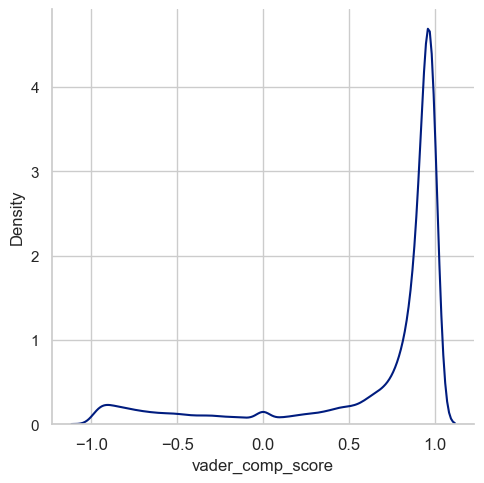

In [128]:
sns.displot(df_review_sample, 
            x="vader_comp_score", kind="kde")

most of the reviews are positive

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


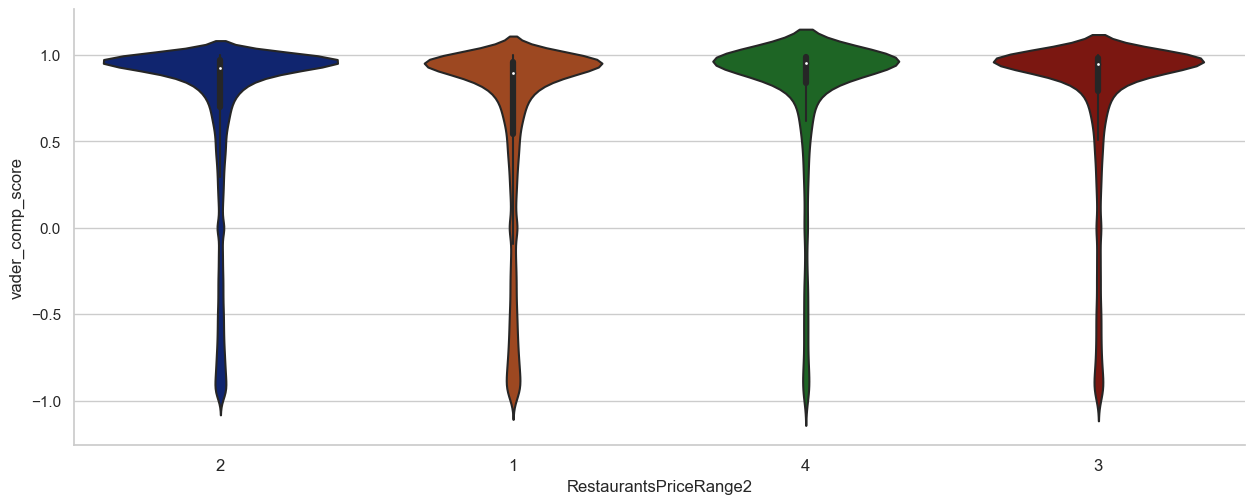

In [130]:
sns.factorplot(x='RestaurantsPriceRange2', 
               y='vader_comp_score' ,
               data = df_review_sample , 
               kind='violin', aspect=2.5)

Mostly sentiments scores across all the price ranges are positive. For the lower priced restaurants (1 & 2), it seems they have more -ve sentiments as compared to high end & premium restaurants

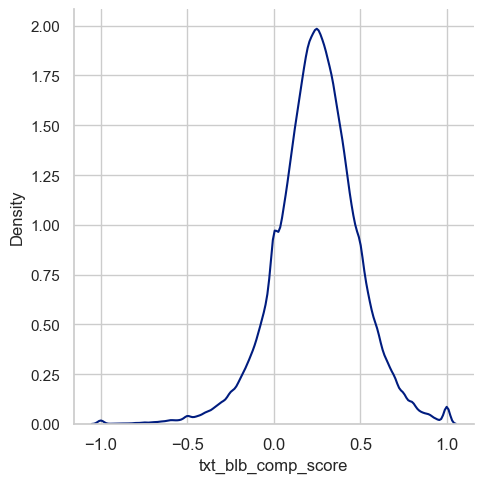

In [131]:
sns.displot(df_review_sample, 
            x="txt_blb_comp_score", kind="kde")

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


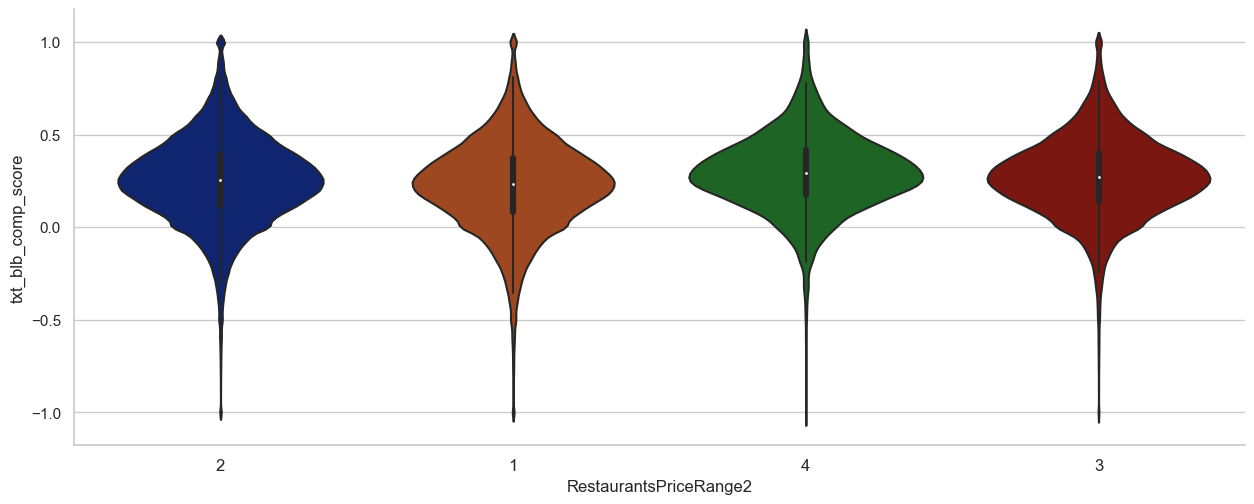

In [132]:
sns.factorplot(x='RestaurantsPriceRange2', 
               y='txt_blb_comp_score' ,
               data = df_review_sample , 
               kind='violin', aspect=2.5)

No Concrete inference can be drawn from text_blob sentiment scores as they are more generic

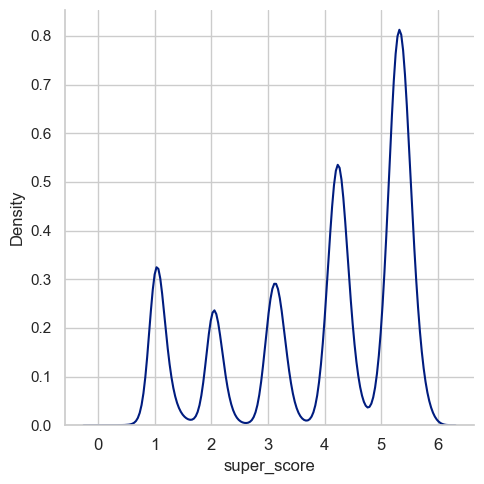

In [134]:
sns.displot(df_review_sample, 
            x="super_score", kind="kde")

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


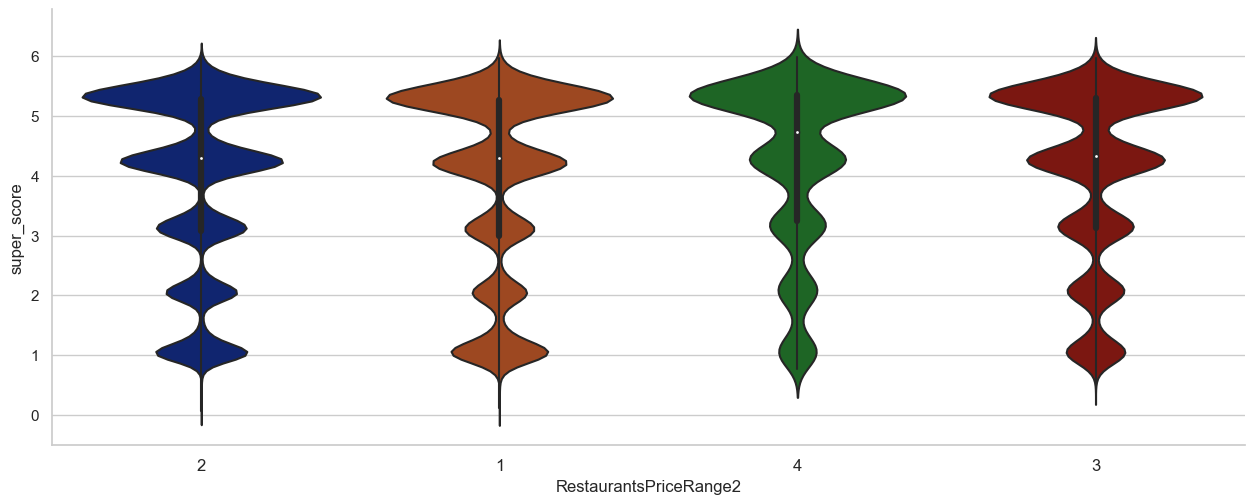

In [135]:
sns.factorplot(x='RestaurantsPriceRange2', 
               y='super_score' ,
               data = df_review_sample , 
               kind='violin', aspect=2.5)

Inference similar to price vs stars as seen in the earlier part

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


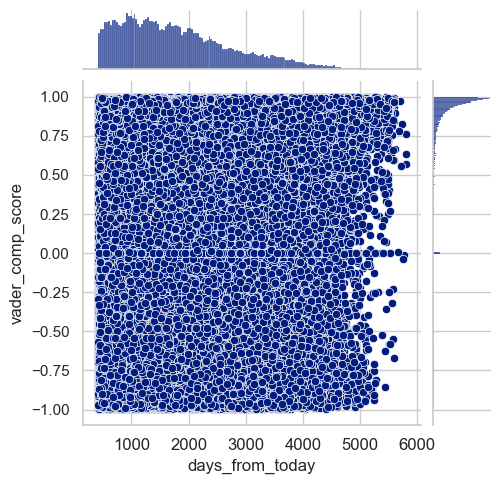

In [136]:
sns.jointplot(x='days_from_today' , y='vader_comp_score' , data=df_review_sample , size=5)

No definitve pattern between age of review (as compared to today) and sentiment score

C:\Anaconda\envs\env_yelp\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


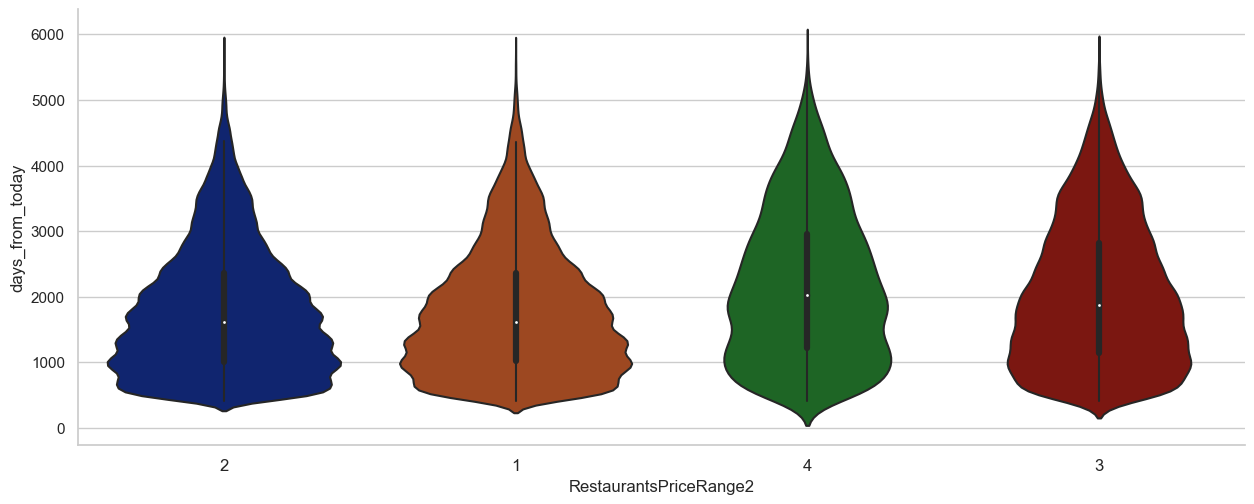

In [137]:
sns.factorplot(x='RestaurantsPriceRange2', 
               y='days_from_today' ,
               data = df_review_sample , 
               kind='violin', aspect=2.5)

Looks like lower priced restaurants tend to be reviewed more frequently possibly due to sheer qunatum of them in the dataset

In [139]:
df_review_sample.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'city', 'is_open', 'RestaurantsPriceRange2',
       'NoiseLevel', 'CoatCheck', 'Alcohol', 'BusinessAcceptsCreditCards',
       'GoodForKids', 'RestaurantsDelivery', 'RestaurantsTakeOut',
       'OutdoorSeating', 'WiFi', 'Is_chain', 'date1', 'days_from_today',
       'vader_comp_score', 'txt_blb_comp_score', 'super_score'],
      dtype='object')

In [141]:
df_review_sample.to_csv("./data/Review_Business_data_Sample.csv", encoding = 'utf-8')